# AS1063: Measure metallicity in image plane

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns

import numpy as np
from scipy import ndimage
import glob

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from reproject import reproject_exact,reproject_interp
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.modeling import models, fitting
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u

# Redshift of AS1063
z = 0.611

## 1) Binning

Base the tesellation on the MUSE data. The lowest flux emission line needed is Hgamma, but it is quite challanging to have a pixel-by-pixel pseudo-narrow band of this line (since it is too faint for gaussian fitting, that's why we are binning!, and the Balmer absoption makes narrow banding the cube hard). Instead we use OII. And do it interactuielly

In [3]:
from voronoi_2d_binning import voronoi_2d_binning

def make_voronoi_tessalation_input(signal,noise,mask=None,out_name='test'):
        p_list      = []
        q_list      = []
        signal_list = []
        noise_list  = []

        if mask is None:
                mask = np.zeros_like(signal)

        for p in range(0,signal.shape[0]):
                for q in range(0,signal.shape[1]):
                        if signal[p,q]>=0 and noise[p,q]>0. and mask[p,q]==1:
                                p_list.append(p)
                                q_list.append(q)
                                signal_list.append(signal[p,q])
                                noise_list.append(noise[p,q])
                        else:
                                continue

        np.savetxt('SNR_'+out_name+'.txt',np.column_stack((p_list,q_list,signal_list,noise_list)),fmt=('%d %d %0.3e %0.3e'),header = 'p q signal noise')

def voronoi_binning(snr_file,targetSN):

    x, y, signal, noise = np.loadtxt(snr_file,unpack=True)
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, signal, noise, targetSN, plot=True, quiet=True)
    np.savetxt(snr_file.replace('SNR','bins_SN_'+str(targetSN)), np.column_stack([x, y, binNum]),
               fmt=b'%10.6f %10.6f %8i')

### 1.1) Load [OII] map and make mask around emission

<IPython.core.display.Javascript object>


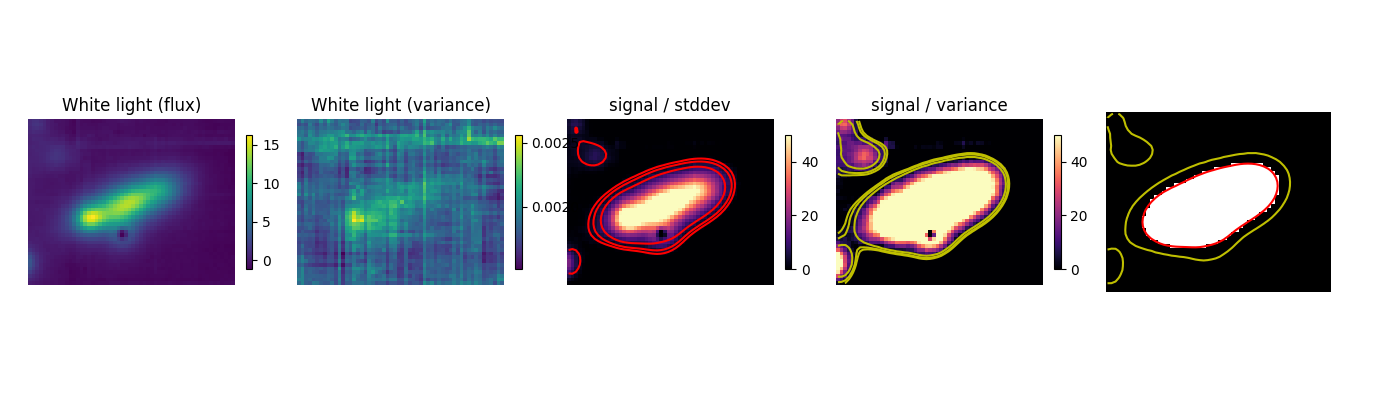

In [4]:
flux = fits.getdata('../../Data/Images/AS1063/Im_AS1063_white_light.fits',ext=1)
var = fits.getdata('../../Data/Images/AS1063/Im_AS1063_white_light.fits',ext=2)

# make mask
mean, median, stddev = sigma_clipped_stats(flux[:20,30:])
smooth = convolve(flux,Gaussian2DKernel(2.2))
mask = np.zeros_like(flux)
mask[np.where(smooth/stddev> 10)] = 1

# plot some images
fig, ax = plt.subplots(1,5,figsize=(14,4))
fig.subplots_adjust(left=0.02,right=0.95)

ax[0].set_title('White light (flux)')
cax = ax[0].imshow(flux,origin='lower')
plt.colorbar(cax,ax=ax[0],fraction=0.03)

ax[1].set_title('White light (variance)')
cax = ax[1].imshow(var,origin='lower')
plt.colorbar(cax,ax=ax[1],fraction=0.03)

snr_map_1 = flux/stddev
snr_map_1_smooth = smooth/stddev
ax[2].set_title('signal / stddev')
cax = ax[2].imshow(snr_map_1,origin='lower',vmin=0,vmax=50,cmap='magma')
plt.colorbar(cax,ax=ax[2],fraction=0.03)
ax[2].contour(snr_map_1_smooth,levels=[3,5,10],colors='r')

snr_map_2 = flux/np.sqrt(var)
snr_map_2_smooth = smooth/np.sqrt(var)
ax[3].set_title('signal / variance')
cax = ax[3].imshow(snr_map_2,origin='lower',vmin=0,vmax=50,cmap='magma')
plt.colorbar(cax,ax=ax[3],fraction=0.03)
ax[3].contour(snr_map_2_smooth,levels=[3,5,10],colors='y')

ax[4].imshow(mask,origin='lower',cmap='Greys_r')
ax[4].contour(snr_map_1_smooth,levels=[10],colors='r')
ax[4].contour(snr_map_2_smooth,levels=[10],colors='y')

dummy = [x.axis('off') for x in ax]

#make_voronoi_tessalation_input(signal=flux,noise=np.sqrt(var),mask=mask, out_name='white_light')
make_voronoi_tessalation_input(signal=flux,noise=np.ones_like(flux)*stddev,mask=mask, out_name='white_light')

<IPython.core.display.Javascript object>


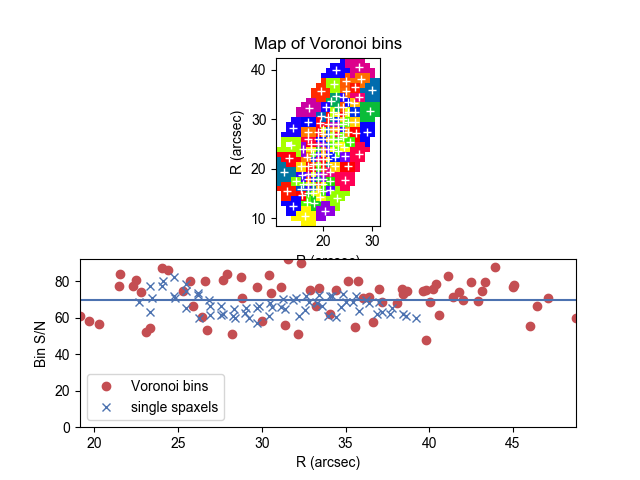

Bin-accretion...
155  initial bins.
Reassign bad bins...
136  good bins.
Modified Lloyd algorithm...
6  iterations.
Unbinned pixels:  65  /  481
Fractional S/N scatter (%): 15.111643092583613
Elapsed time: 0.11 seconds


In [14]:
plt.figure()
voronoi_binning('SNR_white_light.txt',70)

Make map, it will be easier to extract

<IPython.core.display.Javascript object>


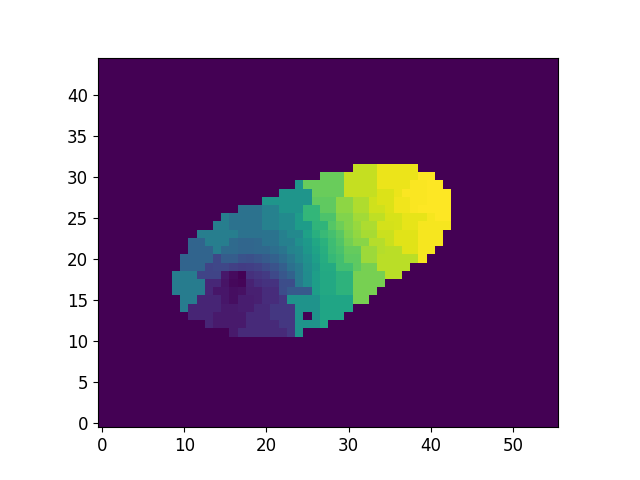

In [13]:
header =  fits.getheader('../../Data/Images/AS1063/Im_AS1063_OII_ContSub_CMSub.fits',ext=1)
vor_map = np.ones_like(flux)*-1

listp, listq , listbin = np.loadtxt('bins_SN_70_white_light.txt',unpack=True)
for p,q,b in zip(listp,listq,listbin):
    vor_map[int(p),int(q)] = b
    
plt.figure()
plt.imshow(vor_map,origin='lower')
fits.writeto('Maps/Map_bins_SN_70.fits',data=vor_map,header=header,overwrite=True)

## 2) Extract spectra and  subtract continuum using pPXF

In [43]:
from ppxf import ppxf
import ppxf_util

def prepare_stellar_libraries(templates,dummyfile):
    
    ## Observed Spectrum. Put it to rest frame
    h1 = fits.getheader(dummyfile)
    gal_lin = fits.getdata(dummyfile)
    lamRange_gal = h1['CRVAL1'] + np.array([0.,h1['CDELT1']*(h1['NAXIS1']-1)])
    FWHM_gal = 2.5/(1+0.611) 

    ## Convert to logscale
    galaxy, logLam_gal, velscale = ppxf_util.log_rebin(lamRange_gal, gal_lin)

    ## Template library : Indo-US
    temp_list = templates
    temp_dir = '/Users/vera/SpectralLibraries/Indo-US/TEXT/'
    (models,met,age) = np.loadtxt(temp_list,skiprows=1,unpack=True,dtype=[('file','S30'),('FeH','f4'),('Teff','f4')])
    dummy_model = models[0].decode('utf8')
    FWHM_temp = 1.35 
    (lbd,star_spec) = np.loadtxt(str(temp_dir)+str(dummy_model),skiprows=31,unpack=True)
    lamRange_temp = [lbd[0],lbd[-1]]
    starNew, logLam_temp, velscale = ppxf_util .log_rebin(lamRange_temp, star_spec, velscale=velscale)
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_temp**2)
    sigma = FWHM_dif/2.355/(lbd[1]-lbd[0])

    dv = (logLam_temp[0]-logLam_gal[0])*299792.458 
        
    star_temp = np.empty((starNew.size,len(models)))
    for j, file in enumerate(models):
            (lbd,spec) = np.loadtxt(temp_dir+file.decode('utf8'),skiprows=0,unpack=True)
            spec = ndimage.gaussian_filter1d(spec,sigma)
            sspNew, logLam_temp, velscale = ppxf_util.log_rebin(lamRange_temp, spec,velscale=velscale)
            star_temp[:,j] = sspNew/np.median(sspNew) 

    ## Mask. Use ppxf routine to calculate good pixels')
    goodpixels = ppxf_util.determine_goodpixels(logLam_gal, lamRange_temp, 0)

    return star_temp, velscale, goodpixels, lamRange_gal, lamRange_temp, dv ,models

### 2.1) Determine best template list

First use the integrated, high SNR spectrum to determine which templates are necessary to fit the data. This will spead up the fit of all the spectra like crazy, since pPXF is quite slow

Fit the intgrated spectra and get the list of the models nedded (to speed up the other fits)

<IPython.core.display.Javascript object>


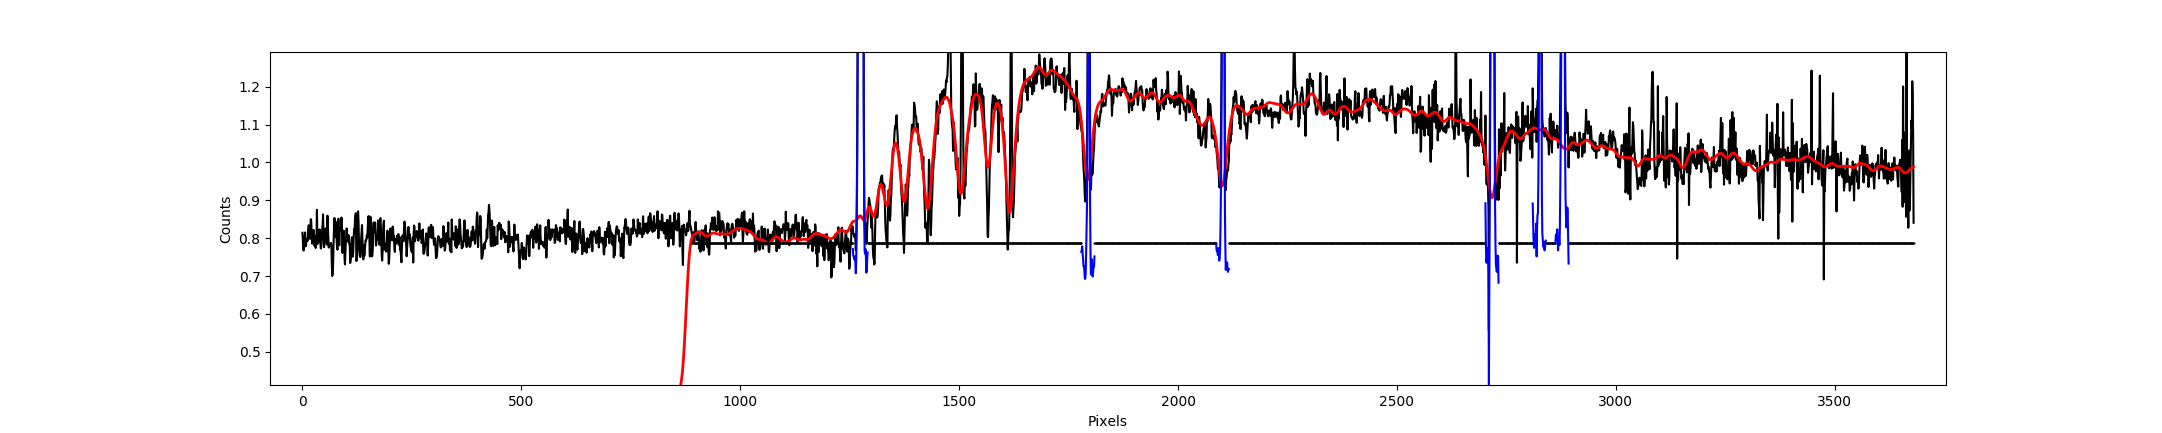

0.0011375316917989293 [-44.4962162  399.61389493]


In [44]:
## load full library
lib = "/Users/vera/SpectralLibraries/Indo-US/TEXT/INDO-US_model_list_no_gaps.txt"
testsp = '../../Data/P18_spectra/Spectrum_AS1063_CMSub_PhotomNorm_restframe.fits'
star_temp, velscale, goodpixels, lamrange_gal, lamRange_temp, dv, models = prepare_stellar_libraries(lib,testsp)

# Prepare input spectra
h1= fits.getheader(testsp)
gal_lin = fits.getdata(testsp)

# Put in in logscale
galaxy, logLam_gal, velscale = ppxf_util.log_rebin(lamrange_gal, gal_lin)
norm = np.median(galaxy)
galaxy /= norm # Normalize spectrum to avoid numerical issues
noise = np.ones_like(galaxy)
goodPix = ppxf_util.determine_goodpixels(logLam_gal, lamRange_temp, 0)

## Fit
plt.figure()
pp = ppxf(star_temp, galaxy, noise, velscale, [0,350], goodpixels=goodPix, vsyst=dv,clean=False,plot=True,quiet=True,degree=0,mdegree=0)
print(pp.chi2,pp.sol)

In [49]:
# Write down template list
total = 0
f  = open('ppxf_as1063_template_list','w')
for m,w in zip(models,pp.weights):
    m = m.decode('utf8')
    if w >0:
        print(m,w)
        total += w
        f.write('%s 0 0 \n'%m)
f.close()

G_48-29.txt 0.08688014294063198
4817.txt 0.013353172765562313
8890.txt 0.0012464806249488176
12533.txt 0.10546984156790089
17506.txt 0.0480672312889593
18778.txt 0.012808113686686865
25291.txt 0.05905177314165909
89254.txt 0.03928780255495475
90277.txt 0.0789678958039683
92055.txt 0.012867597388880372
118244.txt 0.002599440758867994
165195.txt 0.019552870507646484
180163.txt 0.032807805993728865
196777.txt 0.005380196438850672
338529.txt 0.004754396751771425


### 2.2) Extract and fit spectra

Prepare files to fit the cube

In [50]:
as1063_list = "ppxf_as1063_template_list"
testsp = '../../Data/P18_spectra/Spectrum_AS1063_CMSub_PhotomNorm_restframe.fits'
star_temp, velscale, goodpixels, lamrange_gal, lamRange_temp, dv, models = prepare_stellar_libraries(as1063_list,testsp)
h1= fits.getheader(testsp)
wave_original = np.arange(h1['CRVAL1'],h1['CRVAL1']+h1['CDELT1']*h1['NAXIS1'],h1['CDELT1'])

Extra spectra from cube and fit the continuum. Save both spectra

In [54]:
from scipy.stats import tmean

cube = fits.getdata('../../Data/Cubes/smallcube_as1063_rest_frame.fits')
vor_map = fits.getdata('Maps/Map_bins_SN_70.fits')
amp_map = fits.getdata('../../Data/Lensing/AS1063/amp_aligned_with_MUSE.fits')

p, q , listbin = np.loadtxt('bins_SN_70_white_light.txt',unpack=True)

for bin_nb in np.unique(listbin):
        
    # Extract spectrum
    
    # Without magnification correction (not needed for densities)
    idx_map = np.zeros_like(vor_map)*np.nan
    idx_map[np.where(vor_map == bin_nb)] = 1
    new_cube = [cube[k,:,:]/idx_map for k in range(cube.shape[0])]
    gal_lin = np.nanmean(new_cube,axis=(1,2)) 
    
    
    h1['bin_nb'] = bin_nb
    fits.writeto('Spectra/Sp_with_continuum_bin_%d.fits'%bin_nb,data=gal_lin,header = h1)

    # Put in in logscale
    galaxy, logLam_gal, velscale = ppxf_util.log_rebin(lamrange_gal, gal_lin)
    norm = np.median(galaxy)
    galaxy /= norm # Normalize spectrum to avoid numerical issues
    noise = np.ones_like(galaxy)

    ## Fit
    try:
        pp = ppxf(star_temp, galaxy, noise, velscale, [0,350], goodpixels=goodpixels, vsyst=dv,clean=True,plot=False,quiet=True,degree=0)
        ## Return the solution to the same wavelenght and flux as before
        wave = np.exp(logLam_gal) #This has a different step than the original
        continuum = pp.bestfit*norm

        ## Interpolate solution to be able to subtract it to the original spectrum
        continuum_interp = np.interp(wave_original,wave,continuum,left=0,right=0)
        contsub = gal_lin - continuum_interp
        h1['bin_nb'] = bin_nb

        fits.writeto('Spectra/Sp_bin_%d.fits'%bin_nb,data=contsub,header = h1)

    except ValueError:
        print('Not fitted')
        continue

fit with alfa

> python fit_with_alfa.py

print to pdf

<IPython.core.display.Javascript object>


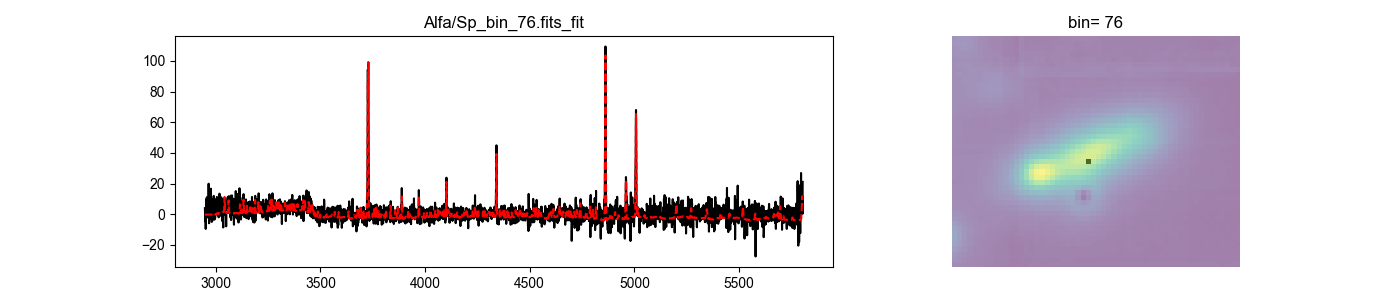

In [57]:
p, q , listbin = np.loadtxt('bins_SN_70_white_light.txt',unpack=True)

fig, ax = plt.subplots(1,2,gridspec_kw={"width_ratios":[2,1]},figsize=(14,3))

for spfile in glob.glob('Alfa/Sp_bin*.fits_fit'):
    
    lbd, sp, fit = np.loadtxt(spfile,usecols=(0,1,2),unpack=True)
    h = fits.getheader(spfile.replace('Alfa/','Spectra/').replace('.fits_fit','.fits'))
    
    idx = np.where(vor_map == h["bin_nb"])
    dummy_im = np.zeros_like(mask) 
    dummy_im[idx] = 1

    #fig.clear()
    ax[0].clear()
    ax[0].plot(lbd,sp,color='k')
    ax[0].plot(lbd,fit,color='r',linestyle='--')
    
    ax[1].clear()
    ax[1].imshow(flux,origin='lower')
    ax[1].imshow(dummy_im,origin='lower',alpha=0.5,cmap='Greys')
    ax[1].axis('off')
    
    ax[0].set_title(spfile)
    ax[1].set_title('bin= %d'%h['bin_nb'])
    
    plt.savefig(spfile.replace('.fits_fit','.pdf'))


Reconstruct the flux maps

In [6]:
def read_fluxes(filename):
        
    lbd, f, err, fwhm  = np.genfromtxt(filename,unpack=True,usecols=(1,2,3,5))
    lbd = list(lbd)
    
    flx = []
    unc = []

    for l in [3726.03, 3728.82, 3868.75 ,4101.74 ,4340.47, 4861.33, 4958.91, 5006.84]:
        if l in lbd:
            flx.append(f[lbd.index(l)])
            unc.append(err[lbd.index(l)]) 
        else:
            flx.append(np.nan)
            unc.append(np.nan)

    return flx, unc

def empty_array(array):
    new = np.zeros_like(array)
    new[:,:] = np.nan
    return new

def reconstruct_maps(alfalist,alfa_name,bin_map_name):
        
    bin_map = fits.getdata(bin_map_name)    
        
    OII_map = empty_array(bin_map)
    NeII_map = empty_array(bin_map)
    Hd_map = empty_array(bin_map)
    Hg_map = empty_array(bin_map)
    Hb_map = empty_array(bin_map)
    OIII4959_map = empty_array(bin_map)
    OIII5007_map = empty_array(bin_map)


    OII_snr = empty_array(bin_map)
    NeII_snr = empty_array(bin_map)
    Hd_snr = empty_array(bin_map)
    Hg_snr = empty_array(bin_map)
    Hb_snr = empty_array(bin_map)
    OIII4959_snr = empty_array(bin_map)
    OIII5007_snr = empty_array(bin_map)

    unc_oii = []
    unc_neii = []
    unc_hd = []
    unc_hg = []
    unc_hb = []
    unc_oiii59 = []
    unc_oiii07 = []
    flux_oii = []
    flux_neii = []
    flux_hd = []
    flux_hg = []
    flux_hb = []
    flux_oiii59 = []
    flux_oiii07 = []
    bin_nb = []


    for alfafile in alfalist:
        flux, unc = read_fluxes(alfafile)

        # To save in a table  
        bin_nb.append(alfafile.replace(alfa_name,'').replace('.fits_lines',''))
        flux_oii.append(np.nansum(flux[0] +flux[1]))
        flux_neii.append(flux[2])
        flux_hd.append(flux[3])
        flux_hg.append(flux[4])
        flux_hb.append(flux[5])
        flux_oiii59.append(flux[6])
        flux_oiii07.append(flux[7])
        unc_oii.append(unc[0] + unc[1])
        unc_neii.append(unc[2])
        unc_hd.append(unc[3])
        unc_hg.append(unc[4])
        unc_hb.append(unc[5])
        unc_oiii59.append(unc[6])
        unc_oiii07.append(unc[7])

        # Make maps
        select = np.where(bin_map == int(bin_nb[-1]))
        OII_map[select] = np.nansum(flux[0] +flux[1])
        NeII_map[select] = flux[2] 
        Hd_map[select] = flux[3] 
        Hg_map[select] = flux[4]
        Hb_map[select] = flux[5]
        OIII4959_map[select] = flux[6]
        OIII5007_map[select] = flux[7]

        OII_snr[select] = np.nansum((flux[0]+flux[1]))/np.nansum((unc[0]+unc[1]))
        NeII_snr[select] = flux[2]/unc[2]
        Hd_snr[select] = flux[3]/unc[3]
        Hg_snr[select] = flux[4]/unc[4]
        Hb_snr[select] = flux[5]/unc[5]
        OIII4959_snr[select] = flux[6]/unc[6]
        OIII5007_snr[select] = flux[7]/unc[7]

    # Make table
    t = Table(data = (bin_nb,flux_oii,flux_neii,flux_hd,flux_hg,flux_hb,flux_oiii59,flux_oiii07,unc_oii,unc_neii,unc_hd,unc_hg,unc_hb,unc_oiii59,unc_oiii07),
                 names= ("bin","f_oii","f_neiii",'f_hd',"f_hg","f_hb","f_oiii59","f_oiii07","unc_oii","unc_neii","unc_hd","unc_hg","unc_hb","unc_oiii59","unc_oiii07"))
    t.sort('bin')
        
    return (OII_map,NeII_map,Hd_map,Hg_map,Hb_map,OIII4959_map,OIII5007_map),(OII_snr,NeII_snr,Hd_snr,Hg_snr,Hb_snr,OIII4959_snr,OIII5007_snr),t
    
def plot_maps(maps,title):
    
    cmap='copper'

    fig, ax = plt.subplots(1,7,figsize=(14,3))
    fig.subplots_adjust(left=0.02,right=0.95)
    fig.suptitle(title)
    cax0 = ax[0].imshow(maps[0],origin='lower',cmap=cmap)
    cax1 = ax[1].imshow(maps[1],origin='lower',cmap=cmap)
    cax2 = ax[2].imshow(maps[2],origin='lower',cmap=cmap)
    cax3 = ax[3].imshow(maps[3],origin='lower',cmap=cmap)
    cax4 = ax[4].imshow(maps[4],origin='lower',cmap=cmap)
    cax5 = ax[5].imshow(maps[5],origin='lower',cmap=cmap)
    cax6 = ax[6].imshow(maps[6],origin='lower',cmap=cmap)

    dummy = [ax[i].set_title('%s (%0.2f,%0.2f)'%(t,np.nanmean(maps[i]),np.nanmin(maps[i]))) for i,t in zip(range(7),['OII','NeII',"Hd","Hg",'Hb','OIII4959','OIII5007'])]
    dummy = [plt.colorbar(c,ax=x,fraction=0.03) for c,x in zip((cax0,cax1,cax2,cax3,cax4,cax5,cax6),ax)]
    dummy = [x.axis('off') for x in ax]
    

def save_maps(maps,name):
    # Save maps
    header = fits.getheader('/Users/vera/Arcs/AS1063/ResolvedProperties/ResolvedMet/camel_fit_withStellar/AS1063_flux_common_HGAMMA.fits')
    fits.writeto('Maps/Map_OII'+name+'.fits',maps[0],header=header,overwrite='True')
    fits.writeto('Maps/Map_NeII'+name+'.fits',maps[1],header=header,overwrite='True')
    fits.writeto('Maps/Map_Hd'+name+'.fits',maps[2],header=header,overwrite='True')
    fits.writeto('Maps/Map_Hg'+name+'.fits',maps[3],header=header,overwrite='True')
    fits.writeto('Maps/Map_OIII4959'+name+'.fits',maps[4],header=header,overwrite='True')
    fits.writeto('Maps/Map_OIII5007'+name+'.fits',maps[5],header=header,overwrite='True')

In [7]:
flux_maps, snr_maps, table = reconstruct_maps(glob.glob('Alfa/Sp_bin*.fits_lines'), 'Alfa/Sp_bin_','Maps/Map_bins_SN_70.fits')

<IPython.core.display.Javascript object>


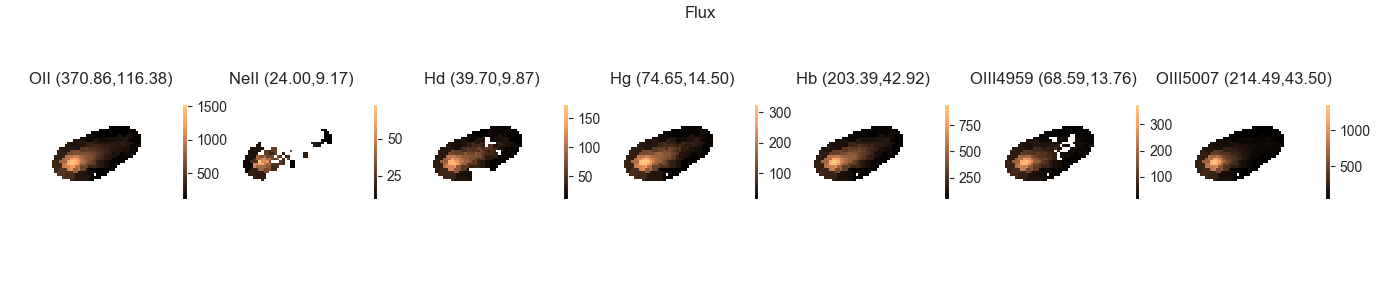

<IPython.core.display.Javascript object>


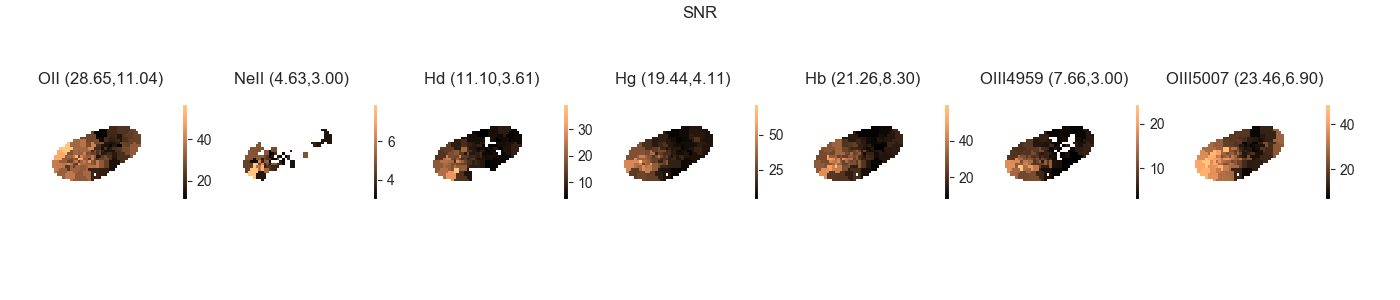

In [8]:
plot_maps(flux_maps,'Flux')
plot_maps(snr_maps,'SNR')
#save_maps(flux_maps,'flux_SNR_70')
#save_maps(snr_maps,'snr_SNR_70')
#table.write('fluxes_bins_SNR_70.dat',format='ascii.fixed_width_two_line')
#t.show_in_notebook()  

### Plots for paper

In [9]:
sns.set_style('dark')

<IPython.core.display.Javascript object>


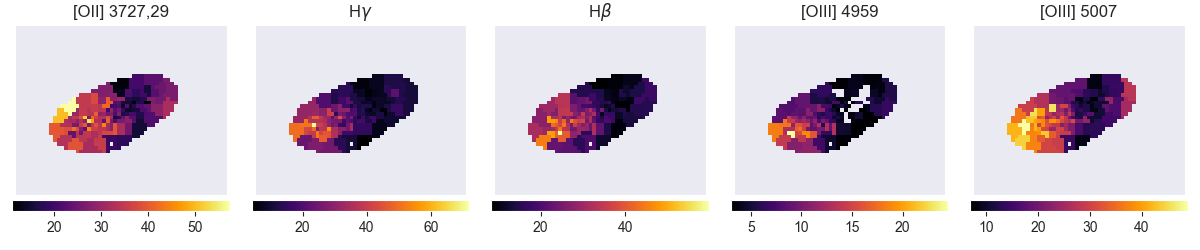

In [8]:
fig, ax = plt.subplots(1,5,figsize=(12,2.5))
fig.subplots_adjust(top=0.90,bottom=-0.1,left=0.01,right=0.99,wspace=0.1)

ax[0].set_title('[OII] 3727,29')
cax = ax[0].imshow(snr_maps[0],origin='lower',cmap='inferno')
plt.colorbar(cax,ax=ax[0],fraction=0.3,orientation='horizontal',pad=0.02)

ax[1].set_title('H$\gamma$')
cax = ax[1].imshow(snr_maps[3],origin='lower',cmap='inferno')
plt.colorbar(cax,ax=ax[1],fraction=0.3,orientation='horizontal',pad=0.02)

ax[2].set_title('H$\\beta$')
cax = ax[2].imshow(snr_maps[4],origin='lower',cmap='inferno')
plt.colorbar(cax,ax=ax[2],fraction=0.3,orientation='horizontal',pad=0.02)

ax[3].set_title('[OIII] 4959')
cax = ax[3].imshow(snr_maps[5],origin='lower',cmap='inferno')
plt.colorbar(cax,ax=ax[3],fraction=0.3,orientation='horizontal',pad=0.02)

ax[4].set_title('[OIII] 5007')
cax = ax[4].imshow(snr_maps[6],origin='lower',cmap='inferno')
plt.colorbar(cax,ax=ax[4],fraction=0.3,orientation='horizontal',pad=0.02)

for x in ax: x.tick_params(labelbottom=False,labelleft=False,bottom=False,left=False)

fig.savefig('../../Plots/as1063_lines_snr.pdf')
fig.savefig('../../Plots/as1063_lines_snr.jpeg')

<IPython.core.display.Javascript object>


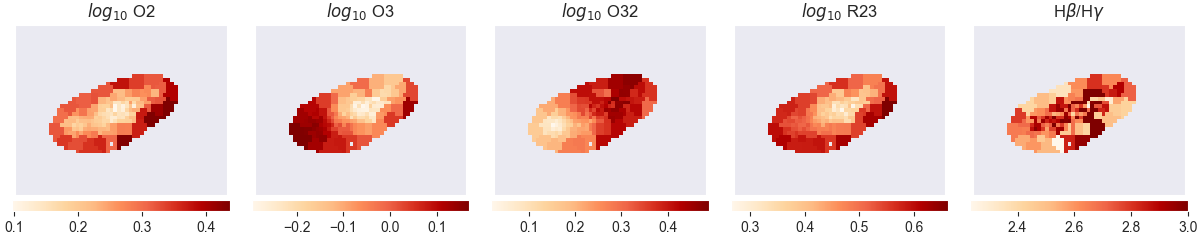

In [10]:
fig, ax = plt.subplots(1,5,figsize=(12,2.5))
fig.subplots_adjust(top=0.90,bottom=-0.1,left=0.01,right=0.99,wspace=0.1)

ax[0].set_title('$log_{10}$ O2')
cax = ax[0].imshow(np.log10(flux_maps[0]/flux_maps[4]),origin='lower',cmap='OrRd')
plt.colorbar(cax,ax=ax[0],fraction=0.3,orientation='horizontal',pad=0.02)

ax[1].set_title('$log_{10}$ O3')
cax = ax[1].imshow(np.log10(flux_maps[6]/flux_maps[4]),origin='lower',cmap='OrRd')
plt.colorbar(cax,ax=ax[1],fraction=0.3,orientation='horizontal',pad=0.02)

ax[2].set_title('$log_{10}$ O32')
cax = ax[2].imshow(np.log10(flux_maps[0]/flux_maps[6]),origin='lower',cmap='OrRd')
plt.colorbar(cax,ax=ax[2],fraction=0.3,orientation='horizontal',pad=0.02)

ax[3].set_title('$log_{10}$ R23')
cax = ax[3].imshow(np.log10(np.nansum(np.dstack((flux_maps[0],flux_maps[5],flux_maps[6])),axis=2)/flux_maps[4]),origin='lower',cmap='OrRd')
plt.colorbar(cax,ax=ax[3],fraction=0.3,orientation='horizontal',pad=0.02)

ax[4].set_title('H$\\beta$/H$\gamma$')
cax = ax[4].imshow(flux_maps[4]/flux_maps[3],origin='lower',vmax=3,cmap='OrRd')
plt.colorbar(cax,ax=ax[4],fraction=0.3,orientation='horizontal',pad=0.02)

for x in ax: x.tick_params(labelbottom=False,labelleft=False,bottom=False,left=False)

fig.savefig('../../Plots/as1063_ratios.pdf')
fig.savefig('../../Plots/as1063_ratios.jpeg')

### Calculate the metallicity maps for each ratio to have an idea of the real uncertainties

<IPython.core.display.Javascript object>


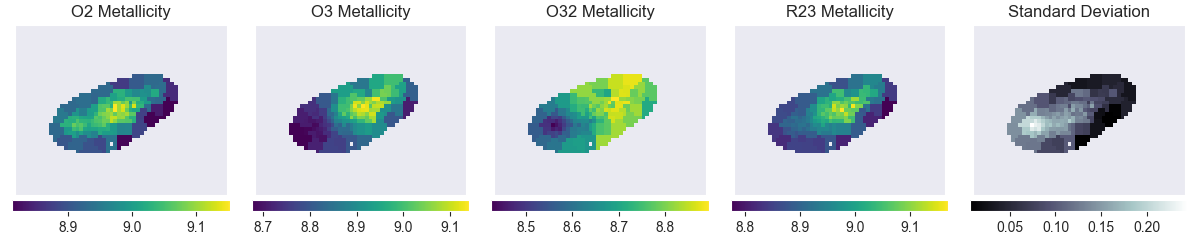

0.09301814 0.24504131


In [11]:
import numpy.polynomial.polynomial as poly
from numpy.polynomial.polynomial import polyval

def R23(R):
    """ From Maiolino+08"""
    c0,c1,c2,c3,c4 =  0.7462, -0.7149, 0.9401, -0.6154,-0.2524
    return polyval(0,(c0-np.log10(R),c1,c2,c3,c4)) + 8.69


def O3(R):
    c0,c1,c2,c3 =  0.1549, -1.5031, -0.9790, -0.0297
    return polyval(0,(c0-np.log10(R),c1,c2,c3)) + 8.69


def O2(R):
    c0,c1,c2,c3,c4 = 0.5603, 0.0450, -1.8017, -1.8434, -0.6549
    return polyval(0,(c0-np.log10(R),c1,c2,c3,c4)) + 8.69


def O32(R):
    c0,c1,c2 = -0.2839,-1.3881,-0.3172
    return polyval(0,(c0-np.log10(R),c1,c2)) + 8.69


#map_R23 = R23(np.nansum((flux_maps[0],flux_maps[5],flux_maps[6]))/flux_maps[4])
map_R23 = R23(np.nansum(np.dstack((flux_maps[0],flux_maps[5],flux_maps[6])),axis=2)/flux_maps[4])
map_O2  = O2(flux_maps[0]/flux_maps[4])
map_O3  = O3(flux_maps[6]/flux_maps[4])
map_O32 = O32(flux_maps[6]/flux_maps[0])


# Plot all 
fig, ax = plt.subplots(1,5,figsize=(12,2.5))
fig.subplots_adjust(top=0.90,bottom=-0.1,left=0.01,right=0.99,wspace=0.1)
cmap_met = 'viridis'

ax[0].set_title('O2 Metallicity')
cax = ax[0].imshow(map_O2,origin='lower',cmap=cmap_met)
plt.colorbar(cax,ax=ax[0],fraction=0.3,orientation='horizontal',pad=0.02)

ax[1].set_title('O3 Metallicity')
cax = ax[1].imshow(map_O3,origin='lower',cmap=cmap_met)
plt.colorbar(cax,ax=ax[1],fraction=0.3,orientation='horizontal',pad=0.02)

ax[2].set_title('O32 Metallicity')
cax = ax[2].imshow(map_O32,origin='lower',cmap=cmap_met)
plt.colorbar(cax,ax=ax[2],fraction=0.3,orientation='horizontal',pad=0.02)

ax[3].set_title('R23 Metallicity')
cax = ax[3].imshow(map_R23,origin='lower',cmap=cmap_met)
plt.colorbar(cax,ax=ax[3],fraction=0.3,orientation='horizontal',pad=0.02)

ax[4].set_title('Standard Deviation')

met_cube = np.dstack((map_O2,map_O3,map_O32,map_R23))
map_std = np.std(met_cube,axis=2)
print(np.nanmean(map_std),np.nanmax(map_std))
cax = ax[4].imshow(map_std,origin='lower',cmap='bone')
plt.colorbar(cax,ax=ax[4],fraction=0.3,orientation='horizontal',pad=0.02)

for x in ax: x.tick_params(labelbottom=False,labelleft=False,bottom=False,left=False)
    
fig.savefig('../../Plots/as1063_metallicity_several_ratios.pdf')
fig.savefig('../../Plots/as1063_metallicity_several_ratios.jpeg')

<IPython.core.display.Javascript object>


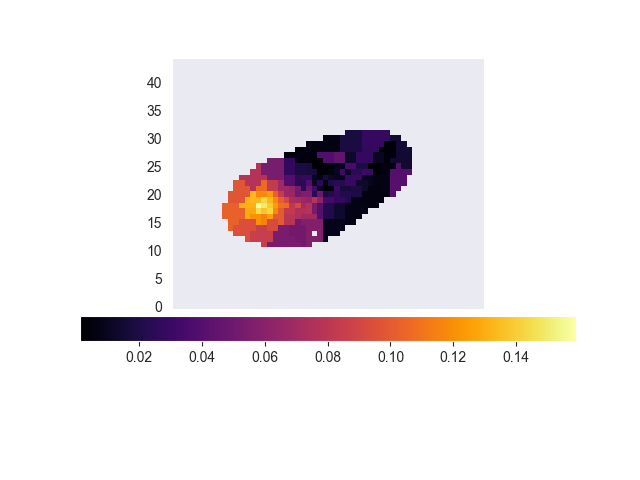

0.045346826 0.15910228


In [12]:
plt.figure()
met_cube = np.dstack((map_O2,map_O3,map_R23))
map_std = np.std(met_cube,axis=2)
print(np.nanmean(map_std),np.nanmax(map_std))
cax = plt.imshow(map_std,origin='lower',cmap='inferno')
plt.colorbar(cax,fraction=0.3,orientation='horizontal',pad=0.02)

## 3) Calculate Metallicity

In [2]:
def prepare_array(filename):
    
    lbd, f, err, fwhm  = np.genfromtxt(filename,unpack=True,usecols=(1,2,3,5))
    lbd = list(lbd)

    cont = fits.getdata(filename.replace('Alfa/Sp_bin_','Spectra/Sp_with_continuum_bin_').replace('.fits_lines','.fits'))
    cont_mean,_, cont_noise = sigma_clipped_stats(cont[2000:2300]) # empty of emission lines
    
    flx = []
    unc = []

    for l in[3726.03, 3728.82, 3868.75 ,4101.74 ,4340.47, 4861.33, 4958.91, 5006.84]:
        try:
            flx.append(f[lbd.index(l)])
            unc.append( np.sqrt(err[lbd.index(l)]**2 + (cont_noise * np.sqrt( 3./2.355*fwhm[lbd.index(l)] + abs(f[lbd.index(l)]/cont_mean/0.725) ))**2))
        except ValueError:
            flx.append(np.nan)
            unc.append(np.nan)
    
    # Put in in the correct order:
          #'[OII]3727',  '[NeIII]','H7',    'Hd',  'Hg',  'Hb',  '[OIII]4959','[OIII]5007','Ha','[NII]6584'
    data = [flx[0]+flx[1],                 flx[2], np.nan, flx[3], flx[4], flx[5], flx[6],   flx[7], np.nan, np.nan]
    err  = [np.sqrt(unc[0]**2+unc[1]**2),  unc[2], np.nan, unc[3], unc[4], unc[5], unc[6],   unc[7], np.nan, np.nan]

    return data, err

In [3]:
## Prepare input files
from met_and_ext_mcmc import make_obs_file

for filename in glob.glob('Alfa/Sp_bin*.fits_lines'):
    try:
        flux, uncertainties = prepare_array(filename)
        make_obs_file(flux,uncertainties,filename.replace('.fits_lines','.obs'))
    except ValueError:
        print(filename)


In [15]:
from met_and_ext_mcmc import print_ratios_ids
print_ratios_ids()

[0] OIII5007/Hb
[1] OII3727/Hb
[2] OIII5007/OII3727
[3] R23
[4] NeIII3870/OII3727
[5] NII6584/Ha
[6] OIII5007/OIII4949
[7] Hd/H7
[8] Hg/H7
[9] Hg/Hd
[10] Hb/Hd
[11] Hb/Hg
[12] Hb/H7
[13] Ha/Hg
[14] Ha/Hd
[15] Ha/H7


In [4]:
from met_and_ext_mcmc import fit_metallicity_and_extinction, calculate_SFR_from_Ha, calculate_SFR_from_OII

## Run mcmc code
met = []
ext = []
emet = []
eext = []
sfr_Hb = []
esfr_Hb = []
sfr_OII = []
esfr_OII = []

# all [0,1,2,3,4,11]
# not ext [0,1,2,3,4]
# R23 [3,11]
# NeII [4,11]
# O3  [0,11]

# Before 0,1,2,3,6,11

spectra = []
for f in glob.glob('Alfa/Sp_bin_*obs'):
    spectra.append(f)
    try:
        mid_m,err_m,mid_t,err_t,samples= fit_metallicity_and_extinction(f,t_range=(0,4),m_range=(8.4,9.5),include=[0,1,2,3,11],
                                                                             extincion_law='Calzetti',nsteps=100,save=False,plot_title=None)
        max_sfr_hb,err_sfr_hb,_= calculate_SFR_from_Ha(samples,f,0.611,nb=100,units=1e-20,use_Hg=False,magerr_over_mag=None)
        max_sfr_oii,err_sfr_oii,_ = calculate_SFR_from_OII(samples,f,0.611,nb=100,units=1e-20,magerr_over_mag=None)
        
        met.append(mid_m)
        emet.append(err_m)
        ext.append(mid_t)
        eext.append(err_t)
        sfr_Hb.append(max_sfr_hb)
        esfr_Hb.append(err_sfr_hb) 
        sfr_OII.append(max_sfr_oii)
        esfr_OII.append(err_sfr_oii) 
    except ValueError:
        print('Did not fit %s'%f)
        met.append(np.nan)
        ext.append(np.nan)
        emet.append(np.nan)
        eext.append(np.nan)
        sfr_Hb.append(np.nan)
        esfr_Hb.append(np.nan) 
        sfr_OII.append(np.nan)
        esfr_OII.append(np.nan) 

MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.97$^{+0.03}_{-0.03}$
Extinction : 0.56$^{+0.09}_{-0.08}$
SFR Balmer: 0.19$\pm$0.02
0.15$\pm$0.03
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.96$^{+0.04}_{-0.04}$
Extinction : 0.44$^{+0.13}_{-0.11}$
SFR Balmer: 0.14$\pm$0.02
0.12$\pm$0.03
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.79$^{+0.02}_{-0.02}$
Extinction : 0.55$^{+0.09}_{-0.07}$
SFR Balmer: 0.56$\pm$0.04
0.40$\pm$0.04
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.77$^{+0.03}_{-0.03}$
Extinction : 0.67$^{+0.08}_{-0.07}$
SFR Balmer: 0.92$\pm$0.06
0.61$\pm$0.07
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.75$^{+0.02}_{-0.02}$
Extinction : 0.66$^{+0.08}_{-0.07}$
SFR Balmer: 0.88$\pm$0.07
0.57$\pm$0.08
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.79$^{+0.03}_{-0.03}$
Extinction : 0.46$^{+0.08}_{-0.07}$
SFR Balmer: 0.26$\pm$0.02
0.18$\pm$0.02
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.98$^{+0.04}_{-0.04}$
Extinction : 0.44$^{+0.12}_{-0.11}$
SFR Balmer:

98.8%
Metallicity : 8.85$^{+0.02}_{-0.03}$
Extinction : 0.50$^{+0.08}_{-0.08}$
SFR Balmer: 0.23$\pm$0.02
0.18$\pm$0.03
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.93$^{+0.02}_{-0.02}$
Extinction : 0.64$^{+0.08}_{-0.07}$
SFR Balmer: 0.40$\pm$0.03
0.29$\pm$0.05
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.84$^{+0.03}_{-0.03}$
Extinction : 0.37$^{+0.09}_{-0.08}$
SFR Balmer: 0.10$\pm$0.01
0.08$\pm$0.01
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.92$^{+0.02}_{-0.03}$
Extinction : 0.58$^{+0.07}_{-0.06}$
SFR Balmer: 0.34$\pm$0.03
0.24$\pm$0.03
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.89$^{+0.03}_{-0.03}$
Extinction : 0.34$^{+0.09}_{-0.08}$
SFR Balmer: 0.06$\pm$0.01
0.05$\pm$0.01
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.90$^{+0.02}_{-0.03}$
Extinction : 0.51$^{+0.08}_{-0.07}$
SFR Balmer: 0.18$\pm$0.01
0.13$\pm$0.02
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.81$^{+0.04}_{-0.03}$
Extinction : 0.42$^{+0.10}_{-0.09}$
SFR Balmer: 0.05$\pm$0.00
0.04$\pm$0.01

98.8%
Metallicity : 8.93$^{+0.04}_{-0.03}$
Extinction : 0.51$^{+0.10}_{-0.09}$
SFR Balmer: 0.19$\pm$0.03
0.15$\pm$0.03
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.85$^{+0.02}_{-0.02}$
Extinction : 0.61$^{+0.08}_{-0.07}$
SFR Balmer: 0.50$\pm$0.04
0.37$\pm$0.05
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.87$^{+0.04}_{-0.03}$
Extinction : 0.26$^{+0.11}_{-0.08}$
SFR Balmer: 0.08$\pm$0.01
0.07$\pm$0.01
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.89$^{+0.03}_{-0.03}$
Extinction : 0.36$^{+0.09}_{-0.09}$
SFR Balmer: 0.08$\pm$0.01
0.06$\pm$0.01
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.82$^{+0.02}_{-0.03}$
Extinction : 0.62$^{+0.09}_{-0.07}$
SFR Balmer: 0.55$\pm$0.05
0.40$\pm$0.08
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.97$^{+0.03}_{-0.03}$
Extinction : 0.48$^{+0.10}_{-0.10}$
SFR Balmer: 0.15$\pm$0.02
0.13$\pm$0.03
MCMCing for 100 steps
 0.0%
98.8%
Metallicity : 8.77$^{+0.02}_{-0.03}$
Extinction : 0.61$^{+0.08}_{-0.07}$
SFR Balmer: 0.71$\pm$0.06
0.50$\pm$0.06

In [5]:
clean_file_name = [z.replace('Alfa/Sp_bin_','').replace('.obs','') for z in spectra]

t = Table(data = (clean_file_name,spectra,met,emet,ext,eext,sfr_Hb,esfr_Hb,sfr_OII,esfr_OII),
          names=('bin','file','met','met_unc','ext','ext_unc','sfr_hb','esfr_hb','sfr_oii','esfr_oii'))
t.sort('bin')
t.write('metallicity_SNR_70_amp_corrected_uncertainties.dat',format='ascii.fixed_width_two_line')
t.show_in_notebook()

idx,bin,file,met,met_unc,ext,ext_unc,sfr_hb,esfr_hb,sfr_oii,esfr_oii
0,0,Alfa/Sp_bin_0.obs,8.76666658452785,0.025420351251608686,0.6723007167613699,0.07473180894357456,0.9240703963691645,0.057796131208844304,0.612629268231868,0.07123300654990883
1,1,Alfa/Sp_bin_1.obs,8.752218399454286,0.023459258203818223,0.6619393941116261,0.0759145731728561,0.8819286865319702,0.06956762723707044,0.5733605350372286,0.08396389436034091
2,10,Alfa/Sp_bin_10.obs,8.735227001290149,0.026905885349061798,0.40553752763334916,0.08123517674026531,0.2942560765324048,0.024906802159192942,0.1916233530682412,0.0291768263673845
3,100,Alfa/Sp_bin_100.obs,8.980955924862286,0.03202644456598236,0.5984910263202277,0.08970480817129334,0.22956296187963424,0.03210172866454353,0.18753030500902243,0.031441023680326904
4,101,Alfa/Sp_bin_101.obs,8.955678985066697,0.02768837114291678,0.5023465597987224,0.07830966327153221,0.1424951762137481,0.015146604069868397,0.11837106080267529,0.01892441814358678
5,102,Alfa/Sp_bin_102.obs,8.8972915420168,0.03182009853163148,0.5177664201545369,0.10038085742419658,0.10300228257232492,0.011689874307218455,0.07284993738795313,0.014978971500492766
6,103,Alfa/Sp_bin_103.obs,8.97039479916582,0.026532175141253056,0.5582040407781819,0.08462391900641575,0.19002187562031017,0.022310749119647477,0.15333207766248028,0.032607229199272725
7,104,Alfa/Sp_bin_104.obs,8.846763777077223,0.042848088997924805,0.2734362136964733,0.12046260487640928,0.0347754144494433,0.005706277985274745,0.028513749042081118,0.0075047189674079424
8,105,Alfa/Sp_bin_105.obs,8.974528426254633,0.03073899178365025,0.6007622536893065,0.08849794455533144,0.206739583741289,0.024967530677725933,0.16620564591956632,0.023251039423764372
9,106,Alfa/Sp_bin_106.obs,8.953294451902758,0.03286332394341418,0.4467554683845367,0.11298061422249284,0.19442649888268898,0.025642259655750343,0.16603646372593006,0.0


In [14]:
t = Table.read('metallicity_SNR_70_amp_corrected_uncertainties.dat',format='ascii.fixed_width_two_line')

met_map = empty_array(mask)
met_unc_map = empty_array(mask)
ext_map = empty_array(mask)
ext_unc_map = empty_array(mask)
sfr_hb_map = empty_array(mask)
sfr_hb_unc_map = empty_array(mask)
sfr_oii_map = empty_array(mask)
sfr_oii_unc_map = empty_array(mask)

for d in t:
    sp_header = fits.getheader('Spectra/Sp_bin_'+str(d['bin'])+'.fits')
    bin_nb = sp_header['bin_nb']
    pix = np.where(vor_map==bin_nb)
    met_map[pix]  = d['met']
    met_unc_map[pix] = d['met_unc']
    ext_map[pix]  = d['ext']
    ext_unc_map[pix] = d['ext_unc']
    sfr_hb_map[pix]  = d['sfr_hb']
    sfr_hb_unc_map[pix]  = d['esfr_hb']
    sfr_oii_map[pix]  = d['sfr_oii']
    sfr_oii_unc_map[pix]  = d['esfr_oii']

header = fits.getheader('../../Data/Images/AS1063/Im_AS1063_OII_ContSub_CMSub.fits',ext=1)
fits.writeto('Maps/Map_metallicity_correct_uncertainties.fits',met_map,header=header,overwrite='True')
fits.writeto('Maps/Map_metallicity_correct_uncertainties_unc.fits',met_unc_map,header=header,overwrite='True')
fits.writeto('Maps/Map_extinction_correct_uncertainties.fits',ext_map,header=header,overwrite='True')
fits.writeto('Maps/Map_extinction_correct_uncertainties_unc.fits',ext_unc_map,header=header,overwrite='True')
fits.writeto('Maps/Map_SFR_Hb_correct_uncertainties.fits',sfr_hb_map,header=header,overwrite='True')
fits.writeto('Maps/Map_SFR_Hb_correct_uncertainties_unc.fits',sfr_hb_unc_map,header=header,overwrite='True')
fits.writeto('Maps/Map_SFR_OII_correct_uncertainties.fits',sfr_oii_map,header=header,overwrite='True')
fits.writeto('Maps/Map_SFR_OII_correct_uncertainties_unc.fits',sfr_oii_unc_map,header=header,overwrite='True')

<IPython.core.display.Javascript object>


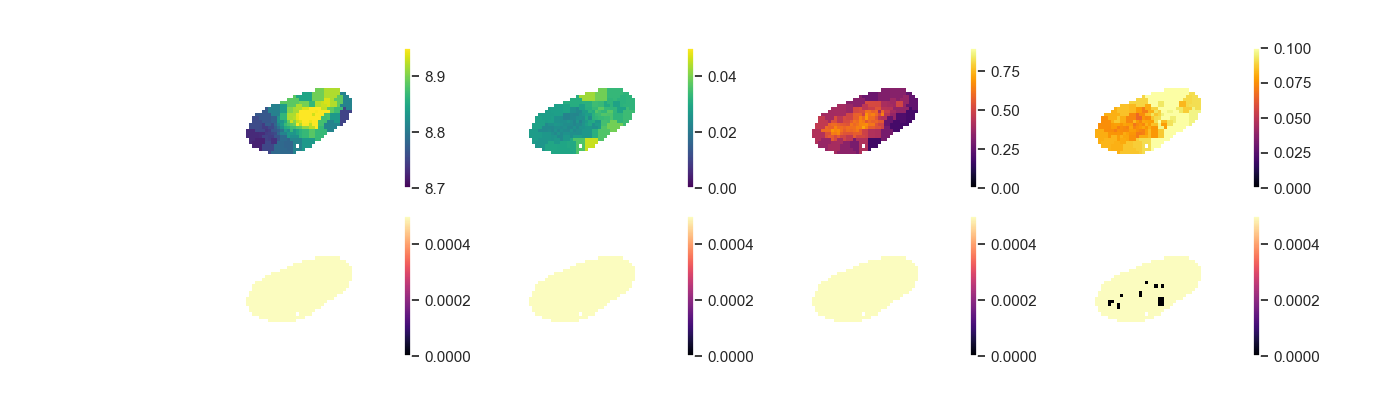

Mean and maximum uncertainty 0.03079015 0.045772407


In [15]:
import seaborn as sns
sns.set(style='dark')

fig, ax = plt.subplots(2,4, figsize=(14,4))
ax = ax.ravel()

cax0 = ax[0].imshow(met_map,origin='lower',vmin=8.7,vmax=8.95,cmap='viridis')
plt.colorbar(cax0,ax=ax[0],fraction=0.03)
cax1 = ax[1].imshow(met_unc_map,origin='lower',vmin=0,vmax=0.05,cmap='viridis')
plt.colorbar(cax1,ax=ax[1],fraction=0.03)
cax2 = ax[2].imshow(ext_map,origin='lower',vmin=0,vmax=0.9,cmap='inferno')
plt.colorbar(cax2,ax=ax[2],fraction=0.03)
cax3 = ax[3].imshow(ext_unc_map,origin='lower',vmin=0,vmax=0.1,cmap='inferno')
plt.colorbar(cax3,ax=ax[3],fraction=0.03)

cax0 = ax[4].imshow(sfr_hb_map,origin='lower',vmin=0,vmax=0.5e-3,cmap='magma')
plt.colorbar(cax0,ax=ax[4],fraction=0.03)
cax1 = ax[5].imshow(sfr_hb_unc_map,origin='lower',vmin=0,vmax=0.5e-3,cmap='magma')
plt.colorbar(cax1,ax=ax[5],fraction=0.03)
cax0 = ax[6].imshow(sfr_oii_map,origin='lower',vmin=0,vmax=0.5e-3,cmap='magma')
plt.colorbar(cax0,ax=ax[6],fraction=0.03)
cax1 = ax[7].imshow(sfr_oii_unc_map,origin='lower',vmin=0,vmax=0.5e-3,cmap='magma')
plt.colorbar(cax1,ax=ax[7],fraction=0.03)

dummy = [x.axis('off') for x in ax]

print('Mean and maximum uncertainty',np.nanmean(met_unc_map),np.nanmax(met_unc_map))

Is it very different from the previous?

<IPython.core.display.Javascript object>


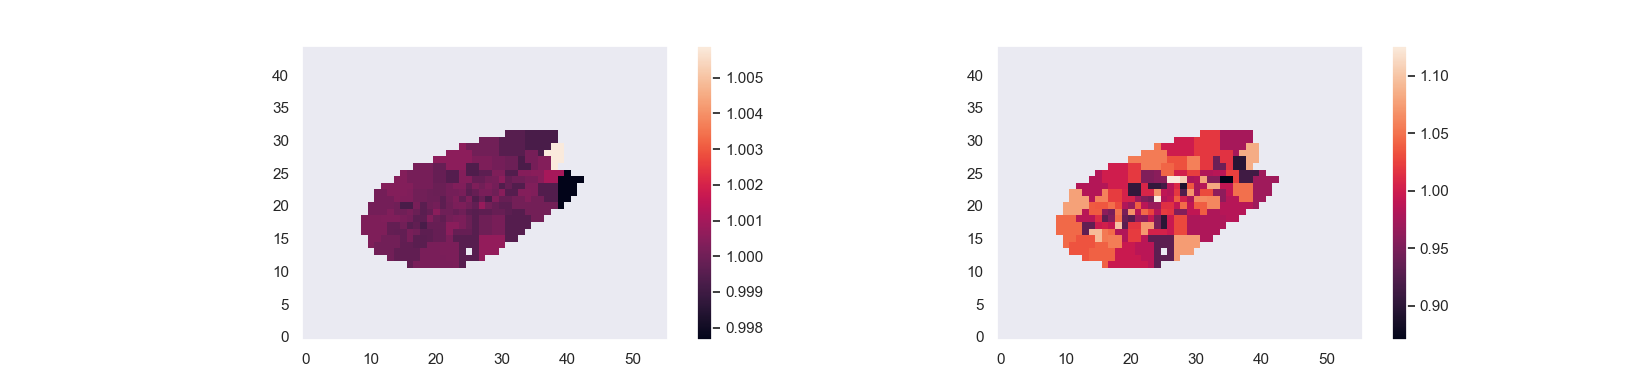

In [18]:
old_met = fits.getdata('Maps/Map_metallicity.fits')
new_met = fits.getdata('Maps/Map_metallicity_correct_uncertainties.fits')

old_unc = fits.getdata('Maps/Map_metallicity_unc.fits')
new_unc = fits.getdata('Maps/Map_metallicity_correct_uncertainties_unc.fits')

fig, ax = plt.subplots(1,2)
cax = ax[0].imshow(new_met/old_met,origin='lower')
plt.colorbar(cax,ax=ax[0])
cax = ax[1].imshow(new_unc/old_unc,origin='lower')
plt.colorbar(cax,ax=ax[1])

The difference is so small that is not really worth bothering about.

### Transform SFR in intrinsic SFR and per kpc

H beta

<IPython.core.display.Javascript object>


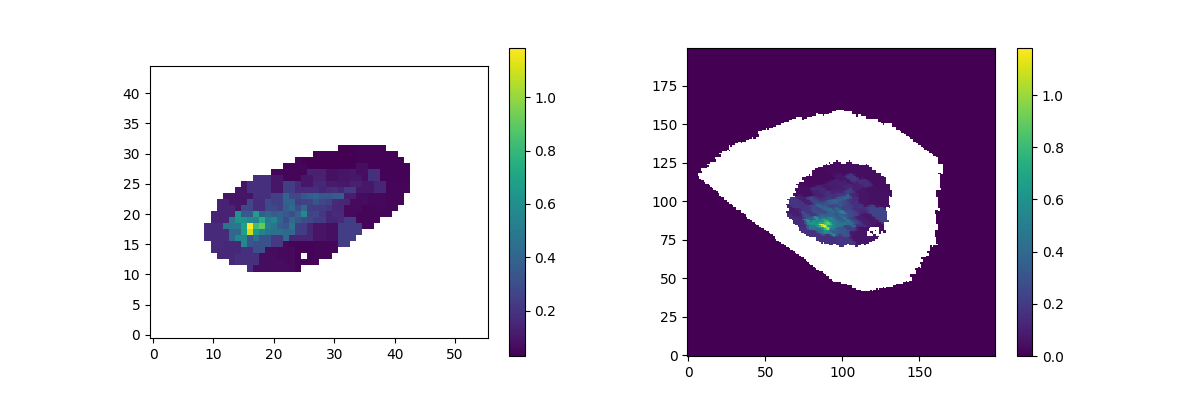

In [2]:
sfr_muse = fits.getdata('Maps/Map_SFR_Hb.fits')
sfr_unc_muse = fits.getdata('Maps/Map_SFR_Hb_unc.fits')
sfr_lenstool = fits.getdata('../../Data/Lensing/AS1063/SP_Maps/SP_Map_SFR_Hb.fits')
header_muse = fits.getheader('Maps/Map_SFR_Hb.fits')
header_lenstool = fits.getheader('../../Data/Lensing/AS1063/SP_Maps/SP_Map_SFR_Hb.fits')

arcsec2_to_kpc2 =  (cosmo.arcsec_per_kpc_proper(0.611).value)**2

# MUSE
pix2_to_arcsec2_muse = 0.2**2
sfr_density_muse = sfr_muse / pix2_to_arcsec2_muse * arcsec2_to_kpc2
sfr_density_unc_muse = sfr_unc_muse / pix2_to_arcsec2_muse * arcsec2_to_kpc2

#Source plane
pix2_to_arcsec2_lenstool = (header_lenstool['CDELT2']*u.deg.to(u.arcsec))**2#0.04**2
sfr_density_lenstool = sfr_lenstool / pix2_to_arcsec2_lenstool * arcsec2_to_kpc2
# compensante for oversampling
sfr_density_lenstool /= 25

# Plot to compare
fig, ax = plt.subplots(1,2,figsize = (12,4))
cax = ax[0].imshow(sfr_density_muse,origin='lower')
plt.colorbar(cax,ax=ax[0])
cax = ax[1].imshow(sfr_density_lenstool,origin='lower')
plt.colorbar(cax,ax=ax[1])

#Save densities
fits.writeto('Maps/Map_SFR_density_Hb.fits',data=sfr_density_muse,header=header_muse, overwrite=True )
fits.writeto('Maps/Map_SFR_density_Hb_unc.fits',data=sfr_density_unc_muse,header=header_muse, overwrite=True )
fits.writeto('../../Data/Lensing/AS1063/SP_Maps/SP_Map_SFR_density_Hb.fits',data=sfr_density_lenstool,header=header_lenstool, overwrite=True )

OII

<IPython.core.display.Javascript object>


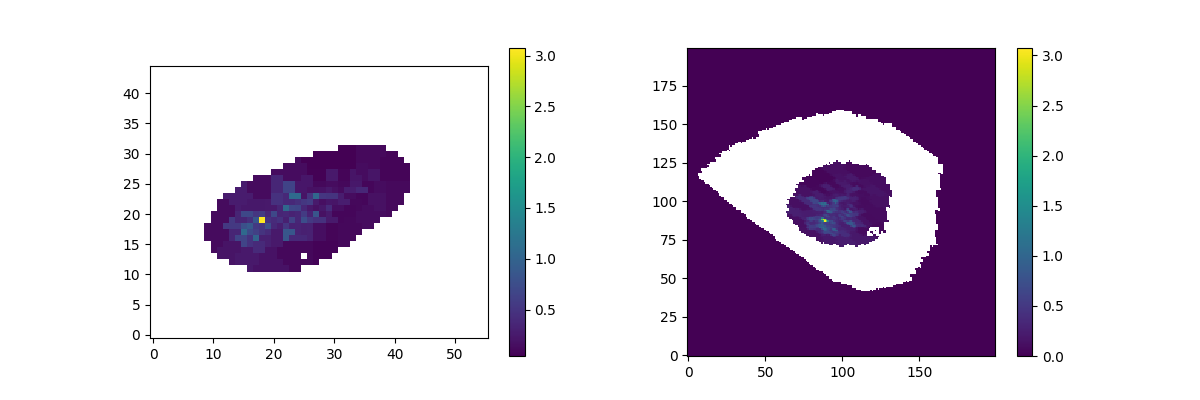

In [3]:
sfr_muse = fits.getdata('Maps/Map_SFR_OII.fits')
sfr_unc_muse = fits.getdata('Maps/Map_SFR_OII_unc.fits')
sfr_lenstool = fits.getdata('../../Data/Lensing/AS1063/SP_Maps/SP_Map_SFR_OII.fits')
header_muse = fits.getheader('Maps/Map_SFR_OII.fits')
header_lenstool = fits.getheader('../../Data/Lensing/AS1063/SP_Maps/SP_Map_SFR_OII.fits')

arcsec2_to_kpc2 =  (cosmo.arcsec_per_kpc_proper(0.611).value)**2

# MUSE
pix2_to_arcsec2_muse = 0.2**2
sfr_density_muse = sfr_muse / pix2_to_arcsec2_muse * arcsec2_to_kpc2
sfr_density_unc_muse = sfr_unc_muse / pix2_to_arcsec2_muse * arcsec2_to_kpc2

#Source plane
pix2_to_arcsec2_lenstool = (header_lenstool['CDELT2']*u.deg.to(u.arcsec))**2#0.04**2
sfr_density_lenstool = sfr_lenstool / pix2_to_arcsec2_lenstool * arcsec2_to_kpc2
# compensante for oversampling
sfr_density_lenstool /= 25

# Plot to compare
fig, ax = plt.subplots(1,2,figsize = (12,4))
cax = ax[0].imshow(sfr_density_muse,origin='lower')
plt.colorbar(cax,ax=ax[0])
cax = ax[1].imshow(sfr_density_lenstool,origin='lower')
plt.colorbar(cax,ax=ax[1])

#Save densities
fits.writeto('Maps/Map_SFR_density_OII.fits',data=sfr_density_muse,header=header_muse, overwrite=True )
fits.writeto('Maps/Map_SFR_density_OII_unc.fits',data=sfr_density_unc_muse,header=header_muse, overwrite=True )
fits.writeto('../../Data/Lensing/AS1063/SP_Maps/SP_Map_SFR_density_OII.fits',data=sfr_density_lenstool,header=header_lenstool, overwrite=True )

# Ploting 

In [13]:
cmap_met = sns.cubehelix_palette(start=3, light=0.95, as_cmap=True)
cmap_ext = sns.cubehelix_palette(start=3.67, light=0.95, as_cmap=True)
cmap_sfr = sns.cubehelix_palette(start=2.0, light=0.88, dark=0.45, as_cmap=True)
sns.set_style('darkgrid')

Load data

In [14]:
met_map = fits.getdata('Maps/Map_metallicity.fits')[5:40,3:46]
ext_map = fits.getdata('Maps/Map_extinction.fits')[5:40,3:46]
sfr_hb_map = fits.getdata('Maps/Map_SFR_density_Hb.fits')[5:40,3:46]

<IPython.core.display.Javascript object>


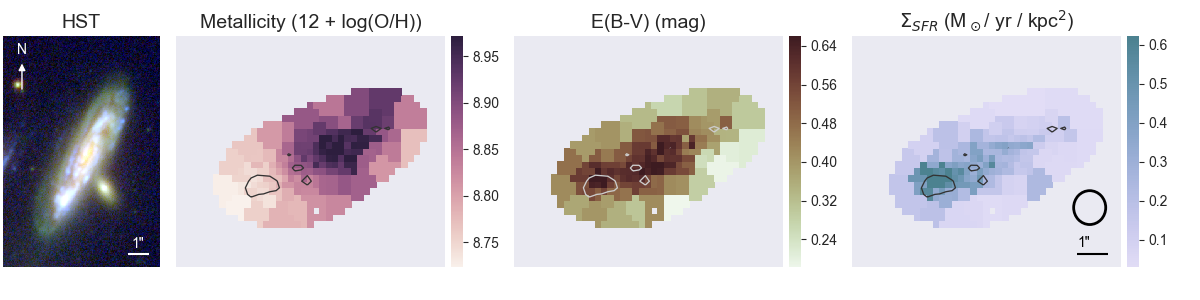

In [22]:
# Set plots
fig, ax = plt.subplots(1,4, figsize=(12,3),gridspec_kw={'width_ratios':[1,2,2,2]})
fig.subplots_adjust(left=0,right=0.98,wspace=0.05)
ax = ax.ravel()

# Plot MUSE data
ax[1].set_title('Metallicity (12 + log(O/H))',fontsize=14)
ax[2].set_title('E(B-V) (mag)',fontsize=14)
ax[3].set_title('$\Sigma_{SFR}$ (M$_\odot$/ yr / kpc$^2$)',fontsize=14)
sns.heatmap(met_map, cmap=cmap_met, ax=ax[1],robust=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})
sns.heatmap(ext_map, cmap=cmap_ext, ax=ax[2],robust=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})
sns.heatmap(sfr_hb_map, cmap=cmap_sfr, ax=ax[3],robust=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})

ax[1].invert_yaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()

#Plot HST RGB data
ax[0].set_title('HST',fontsize=14)
hst = fits.getdata('../../RGB/AS1063_RGB_160_814_435.fits')
blue_hst =  fits.getdata('../../Data/HST/AS1063_F435w.fits')
ax[0].imshow(hst,origin='lower')
#ax[0].contour(blue_hst,colors='r',levels=0.025,linewidths=0.7)
ax[0].axis('off')

# Countours to guide the eye
aligned_blue_hst ,_ =  reproject_interp('../../Data/HST/AS1063_F435w.fits',fits.getheader('../../Data/Images/AS1063/Im_AS1063_OII_ContSub_CMSub.fits',ext=1))
ax[1].contour(aligned_blue_hst[5:40,3:46],levels=[0.015],colors='0.2',linewidths=0.95)
ax[2].contour(aligned_blue_hst[5:40,3:46],levels=[0.015],colors='0.8',linewidths=0.95)
ax[3].contour(aligned_blue_hst[5:40,3:46],levels=[0.015],colors='0.2',linewidths=0.95)

# North East
ax[0].annotate('N',xy=(30, 280),xytext=(30, 340), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w',ha='center')

# Arcsec
#HST : 8.3333333333333E-06 deg per pix
ax[0].hlines(y=20,xmin=200,xmax=200+(1/(8.3333333333333E-06 *3600)),color='w')
ax[0].annotate('1"',xy=(205, 30), color='w',fontsize=10)
ax[3].hlines(y=2,xmin=36,xmax=36+(1/0.2),color='k')
ax[3].annotate('1"',xy=(36, 3), color='k',fontsize=10)

# PSF
psf = plt.Circle((38, 9), 1.0260/0.2/2, color='k',fill=False,linewidth=2)
ax[3].add_artist(psf)

plt.savefig('../../Plots/AS1063_met_map_image_plane_v2.pdf')

## Aligned

In [23]:
met_map, _ = reproject_interp('Maps/Map_metallicity.fits',fits.getheader('../../Data/HST/AS1063_F435w.fits'),order=0)
ext_map, _ = reproject_interp('Maps/Map_extinction.fits',fits.getheader('../../Data/HST/AS1063_F435w.fits'),order=0)
sfr_hb_map, _ = reproject_interp('Maps/Map_SFR_density_Hb.fits',fits.getheader('../../Data/HST/AS1063_F435w.fits'),order=0)

<IPython.core.display.Javascript object>


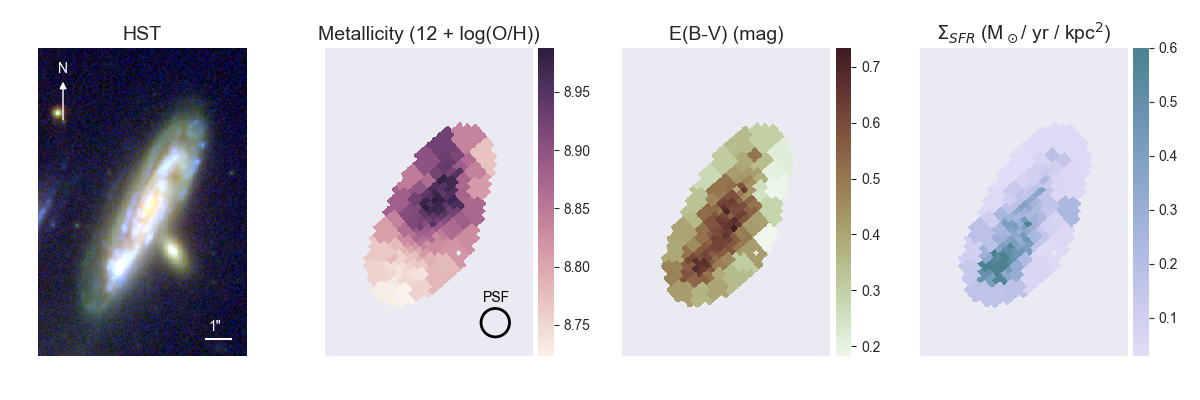

In [24]:
# Set plots
fig, ax = plt.subplots(1,4, figsize=(12,4))
fig.subplots_adjust(left=0,right=0.98,wspace=0.05)
ax = ax.ravel()

# Plot MUSE data
ax[1].set_title('Metallicity (12 + log(O/H))',fontsize=14)
ax[2].set_title('E(B-V) (mag)',fontsize=14)
ax[3].set_title('$\Sigma_{SFR}$ (M$_\odot$/ yr / kpc$^2$)',fontsize=14)
sns.heatmap(met_map, cmap=cmap_met, ax=ax[1],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})
sns.heatmap(ext_map, cmap=cmap_ext, ax=ax[2],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})
sns.heatmap(sfr_hb_map, cmap=cmap_sfr, ax=ax[3],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02},vmax=0.6)

ax[1].invert_yaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()

#Plot HST RGB data
ax[0].set_title('HST',fontsize=14)
hst = fits.getdata('../../RGB/AS1063_RGB_160_814_435.fits')
blue_hst =  fits.getdata('../../Data/HST/AS1063_F435w.fits')
ax[0].imshow(hst,origin='lower')
ax[0].axis('off')

# North East
ax[0].annotate('N',xy=(30, 280),xytext=(30, 340), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w',ha='center')

# Arcsec
#HST : 8.3333333333333E-06 deg per pix
ax[0].hlines(y=20,xmin=200,xmax=200+(1/(8.3333333333333E-06 *3600)),color='w')
ax[0].annotate('1"',xy=(205, 30), color='w',fontsize=10)

# PSF
psf = plt.Circle((205, 40), 1.0260/(8.3333333333333E-06 *3600)/2, color='k',fill=False,linewidth=2)
ax[1].add_artist(psf)
ax[1].annotate('PSF',xy=(190, 65), color='k',fontsize=10)


plt.savefig('../../Plots/AS1063_met_map_image_plane_v2.pdf')

## 2D plots in source plane

version 2

In [25]:
h = fits.getheader('../../Data/Lensing/AS1063/SP_HST/SP_AS1063_F435w.fits')
print('arcsec per pixel',h['CDELT2']*3600)

arcsec per pixel 0.015001122980606867


In [3]:
cosmo.kpc_proper_per_arcmin(0.0611).to('kpc/arcsec') 

<Quantity 1.19124668 kpc / arcsec>

In [4]:
print('kpc per pixel',cosmo.kpc_proper_per_arcmin(0.611).to('kpc/arcsec').value*(h['CDELT2']*3600))

kpc per pixel 0.10268986495297482


<IPython.core.display.Javascript object>


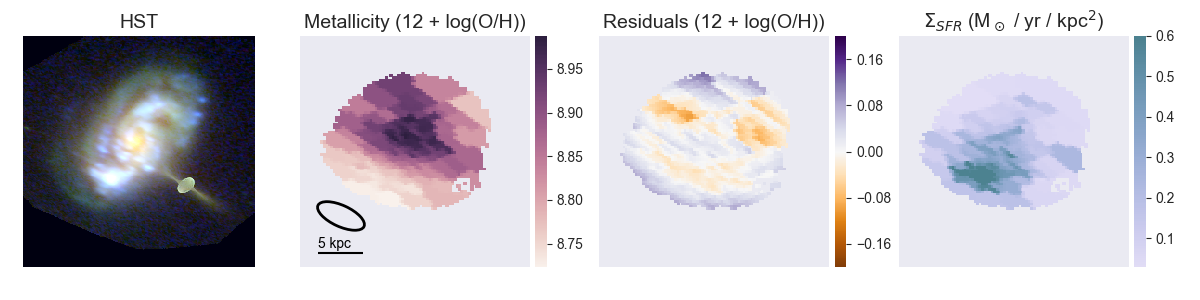

In [29]:
# Set plots
fig, ax = plt.subplots(1,4, figsize=(12,3))
fig.subplots_adjust(left=0,right=0.98,wspace=0.08)
ax = ax.ravel()

# Plot MUSE data
ax[1].set_title('Metallicity (12 + log(O/H))',fontsize=14)
ax[2].set_title('Residuals (12 + log(O/H))',fontsize=14)
ax[3].set_title('$\Sigma_{SFR}$ (M$_\odot$ / yr / kpc$^2$)',fontsize=14)
hst_header = fits.getheader('../../Data/Lensing/AS1063/SP_HST/SP_AS1063_F435w.fits')
met_map, _ = reproject_interp('../../Data/Lensing/AS1063/SP_Maps/SP_Map_metallicity.fits',hst_header,order=0)
ext_map, _ = reproject_interp('../../Data/Lensing/AS1063/SP_Maps/SP_Map_residuals_free_param.fits',hst_header,order=0)
sfr_hb_map, _ = reproject_interp('../../Data/Lensing/AS1063/SP_Maps/SP_Map_SFR_density_Hb.fits',hst_header,order=0)
met_map[np.where(met_map==0)] = np.nan
ext_map[np.where(ext_map==0)] = np.nan
sfr_hb_map[np.where(sfr_hb_map==0)] = np.nan
sns.heatmap(met_map, cmap=cmap_met, ax=ax[1],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})
sns.heatmap(ext_map, cmap='PuOr', ax=ax[2],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02},vmin=-0.2000,vmax=0.2000)
sns.heatmap(sfr_hb_map, cmap=cmap_sfr, ax=ax[3],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02},vmax=0.6)

ax[1].invert_yaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()

#Plot HST RGB data
ax[0].set_title('HST',fontsize=14)
hst = fits.getdata('../../RGB/SP_AS1063_RGB_160_814_435.fits')
ax[0].imshow(hst,origin='lower')
ax[0].axis('off')

#PSF
# 0.10268 pix/kpc
#('fwhm_x ', 2.3684058162247275, ' kpc') --> 2.3684058162247275  / 0.10268  = 23.0
#('fwhm_y ', 5.6922009835475134, ' kpc') --> 5.6922009835475134 / 0.10268 = 55.4
from matplotlib.patches import Ellipse
ax[1].add_artist(Ellipse(xy=(45,55), width=23, height=55, angle=np.rad2deg(1.1401978360210374),edgecolor='k',facecolor='None',linewidth=2))
ax[1].hlines(y=15,xmin=20,xmax=20+(5/0.10268),color='k')
ax[1].annotate('5 kpc',xy=(20, 20), color='k',fontsize=10)

plt.savefig('../../Plots/AS1063_met_map_source_plane_v2.pdf')

# Estimate the Milky Way extinction

<IPython.core.display.Javascript object>


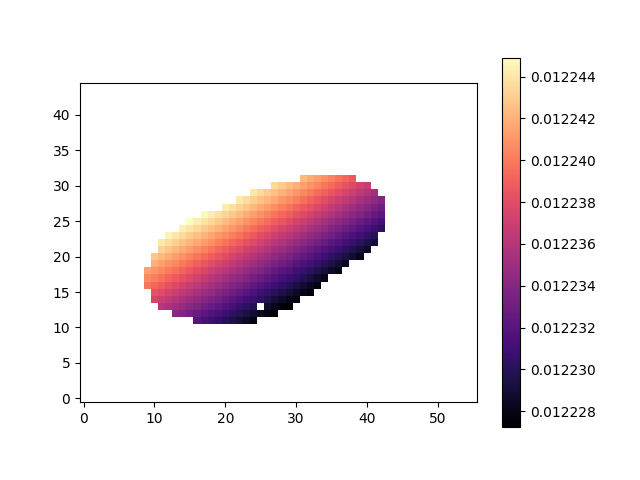

Mean, min and max: 0.012236 0.012227 0.012245


In [13]:
header = fits.getheader('Maps/Map_metallicity.fits')
data = fits.getdata('Maps/Map_metallicity.fits')
dust_map,_ = reproject_interp('/Users/vera/Desktop/AS1063-Dust.fits',header)

dust_map[np.where(np.isnan(data))] = np.nan

plt.figure()
cax = plt.imshow(dust_map,origin='lower',cmap='magma')
plt.colorbar(cax)

print('Mean, min and max: %0.6f %0.6f %0.6f'%(np.nanmean(dust_map),np.nanmin(dust_map),np.nanmax(dust_map)))